<a href="https://colab.research.google.com/github/Tlotlo01/Credit-risk-model/blob/main/Credit_risk_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 0: Install required libraries
!pip install lightgbm imbalanced-learn shap streamlit --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.2 MB/s eta 0:00:00


# **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib
import shap


# **Loading the dataset**

In [13]:
import pandas as pd

url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/openintro/loans_full_schema.csv"
df = pd.read_csv(url)

print("✅ Data loaded:", df.shape)
df.head()


✅ Data loaded: (10000, 56)


,rownames,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,1,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,2,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,3,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,4,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,5,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


#**Preprocessing & target creation**

In [16]:
# Step 1: Check columns
print(df.columns.tolist())

# Step 2: Update feature names based on actual dataset
features = [ 'loan_amount', 'interest_rate', 'installment',
    'annual_income', 'debt_to_income', 'emp_length',
    'homeownership', 'loan_purpose']

# Step 3: Subset and clean
df = df[features + ['target']].dropna()



['rownames', 'emp_title', 'emp_length', 'state', 'homeownership', 'annual_income', 'verified_income', 'debt_to_income', 'annual_income_joint', 'verification_income_joint', 'debt_to_income_joint', 'delinq_2y', 'months_since_last_delinq', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_120d_past_due', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'loan_purpose', 'application_type', 'loan_amount', 'term', 'interest_rate', 'installme

# **Encode categorical variables**

In [21]:
df['emp_length'] = df['emp_length'].astype(str).replace({
    '10+ years': '10', '< 1 year': '0', '1 year': '1', '2 years': '2',
})
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float).fillna(0).astype(int)

# Label encode categoricals
from sklearn.preprocessing import LabelEncoder
for col in ['homeownership', 'loan_purpose']:
    df[col] = LabelEncoder().fit_transform(df[col])


# **Train-test split and balancing**

In [27]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split into features and target
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Before SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
sm = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)

# After SMOTE
print("After SMOTE:", Counter(y_res))



Before SMOTE: Counter({0: 7340, 1: 5})
After SMOTE: Counter({0: 7340, 1: 7340})


# **Scale numeric features**

In [30]:
from sklearn.preprocessing import StandardScaler

num_cols = ['loan_amount', 'interest_rate', 'installment', 'annual_income', 'debt_to_income']

scaler = StandardScaler()
X_res[num_cols] = scaler.fit_transform(X_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])



# **Train a LightGBM classifier with basic tuning**

In [32]:
model = lgb.LGBMClassifier(random_state=42)
param_grid = {'num_leaves': [31, 50], 'n_estimators': [100, 200]}
grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_res, y_res)
best_model = grid.best_estimator_
print(grid.best_params_)


[LightGBM] [Info] Number of positive: 4893, number of negative: 4893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 9786, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4894, number of negative: 4893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 9787, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500051 -> initscore=0.000204
[L

# **Evaluate on test set**

In [33]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))


ROC AUC: 0.615
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1836
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1837
   macro avg       0.50      0.50      0.50      1837
weighted avg       1.00      1.00      1.00      1837



# **Save model and scaler**

In [35]:
joblib.dump(best_model, 'credit_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ Model and scaler saved")


✅ Model and scaler saved


# **Feature importance with SHAP**

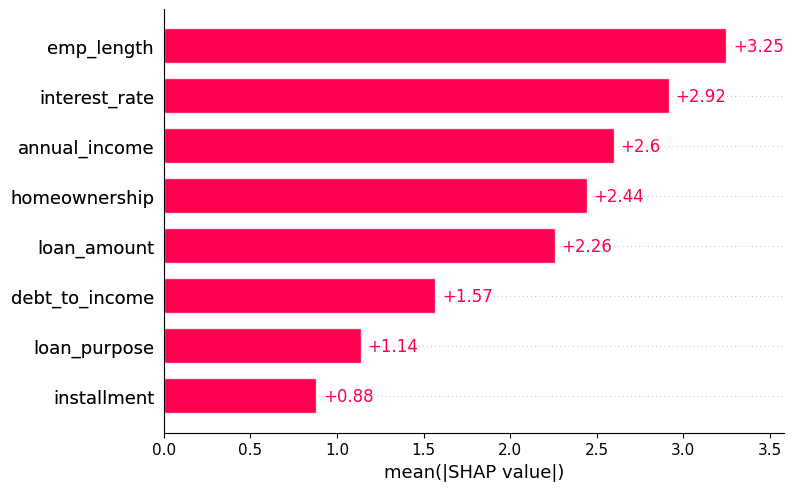

In [37]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_model)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.plots.bar(shap_values)



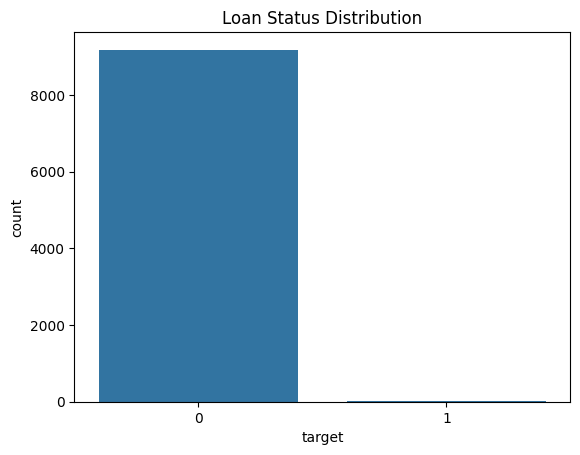

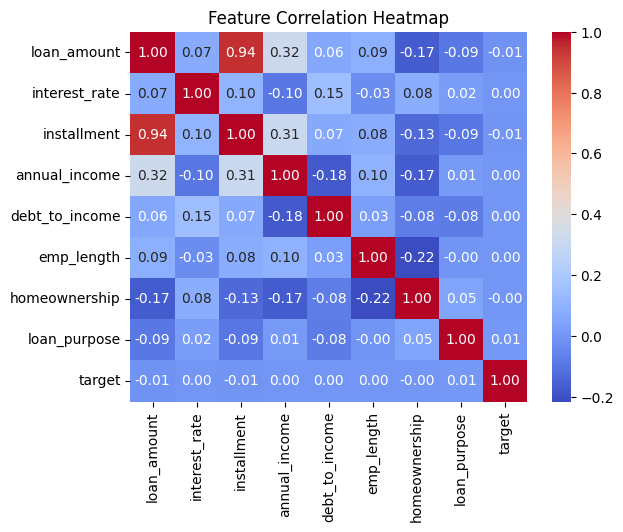

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of target classes
sns.countplot(x='target', data=df)
plt.title("Loan Status Distribution")
plt.show()

# Correlation heatmap
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
